# Implementation of Grover's Algorithm using 2 qubits:

In this tutorial we will get a fundamental knowledge of the infamous Grover's Search Algorithm. We will understand the steps of the algorithm with an easy example using 2 qubits and finally implement the circuit initialized using 2 qubits in a simulator and real quantum device.

Grover's algorithm is a speed-searching algorithm that demonstrates Quantum superiority over classical algorithms. 

Many of us must have heard about the linear search algorithm: you are given a sorted set of data and you are to keep looking for the desired data-point until you find it. And so, the time complexity is directly related to the size of the data-set. However, Grover's search algorithm can speed up the search process quadratically. Let us consider a simple a scenario to get the intuition.

Suppose, you are given a list of $N$ number of boxes and based on a unique property, you want to find a specific box. Classically, you need to make boolean query for $\frac{N}{2}$ (average) times and in worst case for $N$ times. But Grover's algorithm will help us find the box with roughly $\sqrt N$ steps based on amplitude amplification technique. Each box in the list is mapped as a possible state of qubits (e.g 8 ($2^N$) boxes need 3 qubits to be represented) and hence has a $\frac{1}{\sqrt N}$ probability of being the one we are looking for. Amplitude of the desired state is amplified which results in amplitude shrinkage of others so that each of the probabilities add up to unity. 

Now that we have amplified the amplitude, we apply the reflection oracle which basically adds negative phase to the solution state.

For |X$\rangle$, oracle is defined as: 

$$U_\omega |x\rangle = \begin{cases}
  |x\rangle &  x \ne \omega \\
-|x\rangle &  x = \omega
\end{cases}$$

So graphically, the solution state has been reflected as follows: 

<img src="https://upload.wikimedia.org/wikipedia/commons/1/16/Grovers_algorithm_geometry.png" width="250" height="75">

As we iterate the steps (amplitude amplification and reflect oracle) the probability of solution state after measurement reaches ideally close to 1  (number of iteration doesn't affect time complexity).  Now, let us try to implement our understanding using simple Qiskit codes:

### Step-1# Loading account and importing necessary libraries: 

In [1]:
# Importing standard Qiskit libraries:
import numpy as np     
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
# Loading your IBM Quantum account(s):
provider = IBMQ.enable_account('')

### Step-2# Circuit initialization and defining corresponding oracle: 

In order to implement the algorithm we first need all of the qubits (2 in this example) in an uniform superposition state which can be achieved using the Hadamard gate on each qubit.

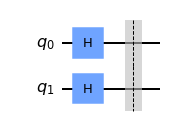

In [2]:
## Creating function for Equal Superposition states of two qubits:
def initialize(qc):
    qc.h(0)         # Applying H gates to both qubits
    qc.h(1)         # and initializing grover circuit
    qc.barrier()
grover_circuit = QuantumCircuit(2)
initialize(grover_circuit)
grover_circuit.draw('mpl')

Let's try to find the position of desired state (in this case) |11$\rangle$:

Here we try to understand how can we make an oracle for the required state:

The oracle for state |11$\rangle$ acts as follows-
$$U_\omega |s\rangle = U_\omega \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle) = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle - |11\rangle) $$

and in the matrix form it corresponds to
$$U_\omega =\left[ \begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & -1
\end{array}
\right]$$
Looking more closely we will be able to recognize that using the controlled Z gate on the state equally superposition state of |00\rang we can achieve this state.

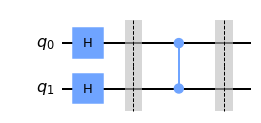

In [3]:
def oracle_11(qc): 
	qc.cz(0,1)          # Apply a controlled Z gate
	qc.barrier()
oracle_11(grover_circuit)
grover_circuit.draw('mpl')

### Step-3# Grover's diffusion operator:

For completing the circuit, we need to use additional reflection and mainly the diffuser works to amplify the required states probability amplitude where else shrinks the that of other items. 

Constructing the complete circuit

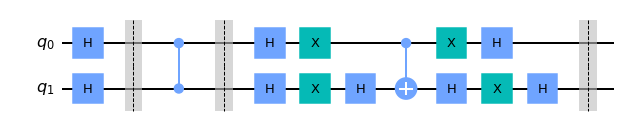

In [4]:
# Creating Grover's Diffusion operator:
def u_g(qc):
  qc.h(0)
  qc.h(1)
  qc.x(0)
  qc.x(1)
  qc.h(1)
  qc.cx(0,1)
  qc.x(0)
  qc.h(1)
  qc.h(0)
  qc.x(1)
  qc.h(1)
  qc.barrier()
u_g(grover_circuit)        # temporary circuit just to see what U_s looks like
grover_circuit.draw('mpl')

Adding measurement basis:

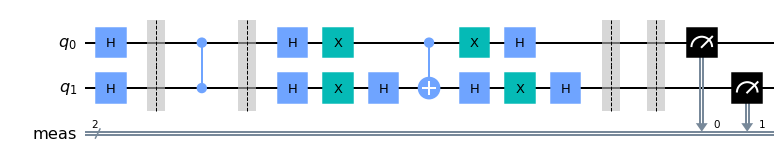

In [5]:
# Finally we measure the circuit:
grover_circuit.measure_all()
grover_circuit.draw('mpl')

Adding measurement basis:

### Step-4# Running the Grover's circuit on a simulator:

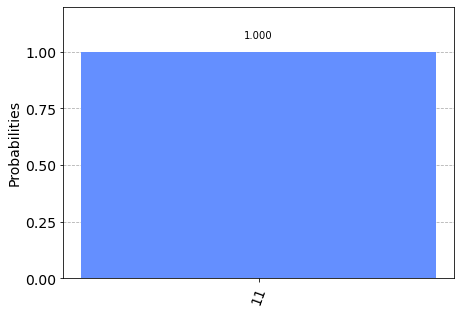

In [6]:
# Simulating the Circuit:
backend = Aer.get_backend('qasm_simulator')
job = execute(grover_circuit, backend, shots = 1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Step-5# Running it on a real quantum device:

In [7]:
# Experimenting with real device:
#IBMQ.load_account()
# Getting the least busy backend:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_manila


In [8]:
# Running the circuit on the least busy backend. Monitor the execution of the job in the queue:
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_grover_circuit)
job = backend.run(qobj)
job_monitor(job, interval=2)

<ipython-input-8-f016e18a0d01>:5: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


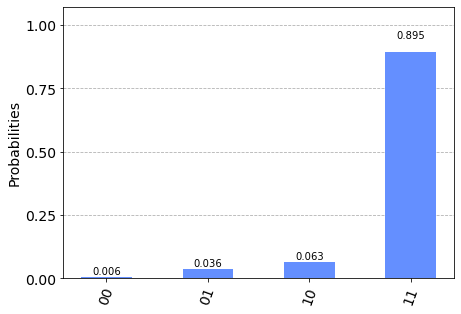

In [9]:
# Getting the results from the computation:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

Here, we can see that the probability of our desired state (|11$\rangle$) is significantly higher than rest other states and thus easily distinguishable.